<a href="https://colab.research.google.com/github/saavedramarcosdavid/Aprendizaje-de-Maquina/blob/main/Clase5/Clase_5_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de máquina - Clase 5

## Ejercicio 5
Elegir uno de entre los siguientes proyectos sugeridos y aplicar clustering para resolverlo. Cada proyecto tiene datasets de diferentes características y dificultad

## Proyecto seleccionado: Crímenes violentos en los estados de EEUU
El dataset contiene registros de crímenes ocurridos durante 1973 en EEUU en diferentes estados, así como el porcentaje de la población que vive en zonas urbanas en dichos estados. El objetivo es agrupar a estos estados en diferentes categorías de acuerdo a estos factores.


### Carga y análisis del Dataset
Este conjunto de datos contiene estadísticas, en arrestos por cada 100,000 residentes por agresión, asesinato y violación en cada uno de los 50 estados de EE. UU. en 1973. También se proporciona el porcentaje de la población que vive en áreas urbanas. 

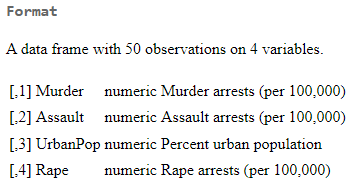

In [126]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectUSA/data/violent_crime.csv")
df.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [127]:
df = df.rename(columns={
    "Unnamed: 0": "state",
    "Murder": "asesinatos",
    "Assault": "asaltos",
    "UrbanPop": "poblaUrbana",
    "Rape": "violaciones"
})

df = df.set_index(df['state']).drop('state', axis=1)
df.head()

,asesinatos,asaltos,poblaUrbana,violaciones
state,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asesinatos   50 non-null     float64
 1   asaltos      50 non-null     int64  
 2   poblaUrbana  50 non-null     int64  
 3   violaciones  50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [129]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
asesinatos,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
asaltos,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
poblaUrbana,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
violaciones,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


Se realiza un análisis de valores atípicos de cada una de las columnas del conjunto de datos. Sin embargo, no se eliminan las filas que los presentan dado que solo se trata de 2 valores atípicos en el atributo *Rape* y al tratarse de un conjunto de datos de pocas filas, no sería provechoso suprimirlas. 

In [130]:
import numpy as np

def atipicos_columna(y, column):
    '''
        Busca y cuenta los atípicos en un vector pasado por parámetro.
        Se basa en el rango intercuartil.
    '''
    # Calcular rango intercuartil
    y_df = pd.DataFrame({'y': y})

    q25, q75 = np.percentile(y_df['y'], 25), np.percentile(y_df['y'], 75)
    iqr = q75 - q25

    # Calcule el rango de valores atípicos
    k = 1.5
    range_ir = iqr * k

    # Límites
    lower_bound_ir, upper_bound_ir = q25 - range_ir, q75 + range_ir

    # Creacion de mascaras y busqueda de atípicos y no atípicos
    outliers_mask_ir = [True if x < lower_bound_ir or x > upper_bound_ir else False for x in y_df['y']]
    no_outliers_mask_ir = [False if x < lower_bound_ir or x > upper_bound_ir else True for x in y_df['y']]

    outliers = y_df['y'][outliers_mask_ir]
    no_outliers = y_df['y'][no_outliers_mask_ir]

    print("-- Columna: ",column,"   \t->",outliers.shape[0])

def atipicos(df, inicio = 0):
    '''
        Busca y cuenta atípicos en todo el DataFrame pasado por parámetro
    '''
    print("Cantidad de atipicos: ")
    for column in df.columns[inicio:]:
        atipicos_columna(df[column].values, column)

In [131]:
atipicos(df)

Cantidad de atipicos: 
-- Columna:  asesinatos    	-> 0
-- Columna:  asaltos    	-> 0
-- Columna:  poblaUrbana    	-> 0
-- Columna:  violaciones    	-> 2


Visualización de las distribuciones de cada una de las variables

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_hist(data,title, ax):
    '''
        print_hist:
            Función para dibujar el histograma y la distribución de los datos.
    '''
    sns.histplot(data, alpha=0.4, kde=True, ax=ax)
    sns.rugplot(data, color="black", ax=ax)
    
    color = "orange"
    text=f"$\\mu$ = {data.mean():.3f}\n"
    text+=f"$\\sigma$ = {data.std(ddof=1):.3f}"

    bbox = dict(boxstyle='round', fc=color, ec=color, alpha=0.3)
    ax.text(0.72, 0.8, text, fontsize=11, bbox=bbox, transform=ax.transAxes)
    ax.set_title(title)

def print_dataset(df, fig_rows, fig_cols):
    '''
        print_dataset:
            Recibe un DataFrame, dibuja sus distribuciones de datos y cuenta cuántos tienen distribución normal
    '''
    cols = df.columns
    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=((fig_cols*25)//5, (fig_rows*8)//2))
    axes = axes.ravel()

    for col_name, ax in zip(cols, axes):
        print_hist(df[col_name],"Distribución de " + col_name, ax)

    fig.tight_layout()
    plt.show()

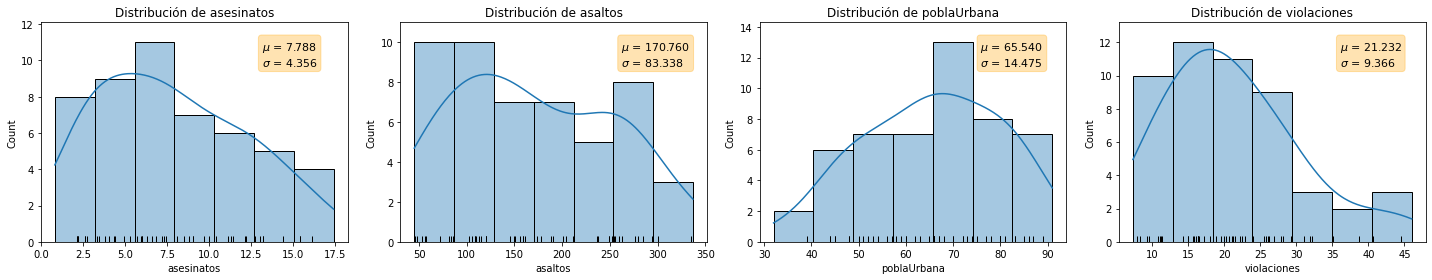

In [133]:
print_dataset(df, 1, 4)

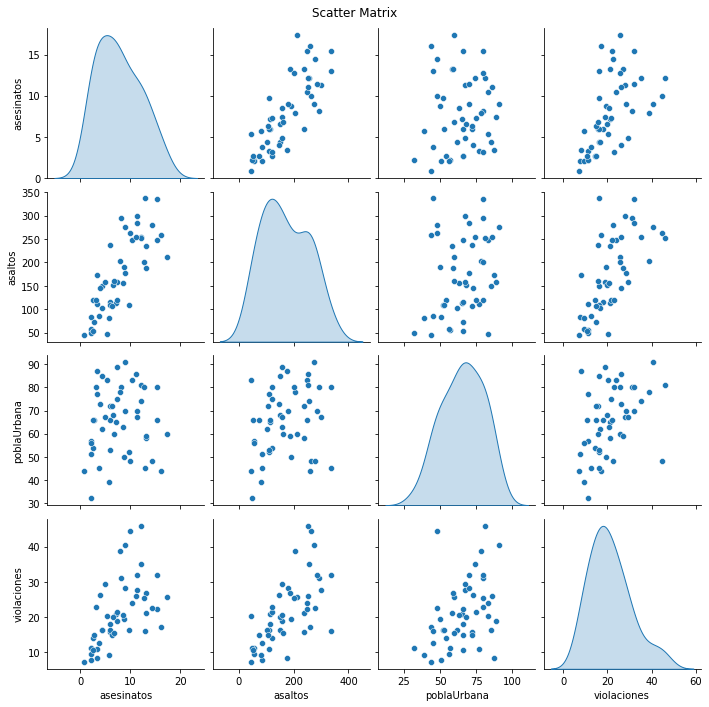

In [134]:
pg = sns.pairplot(data = df, diag_kind='kde')
pg.fig.suptitle('Scatter Matrix')
pg.fig.subplots_adjust(top=0.95)

Se puede observar que los asaltos y los asesinatos se encuentran altamente correlacionados. En menor medida las violaciones están medianamente correlacionados con dichas variables. 

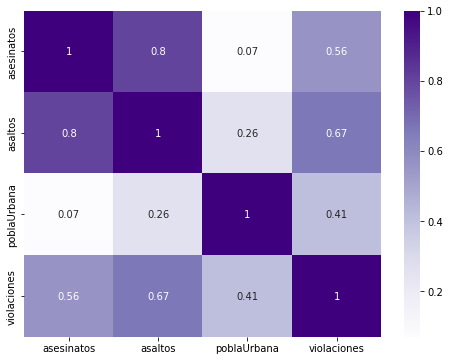

In [135]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="Purples")
plt.show()

### Escalamiento de los datos
Dado que el dataset utilizado es pequeño se probarán distintos tipos de escalamientos basados en normalización, estandarizacion, y tres opciones de normalizacion brindadas por *sklearn.preprocessing*.

Se realiza esto con el fin de determinar el efecto del escalamiento en los datos.

In [136]:
from sklearn.preprocessing import normalize

def normalizacion(x):
    x = x/x.max()
    return x

def estandarizacion(x):
    x_mean= x.mean()
    x_std= x.std()
    
    x = (x-x_mean)/x_std
    return x

Aplicando normalizacion: 


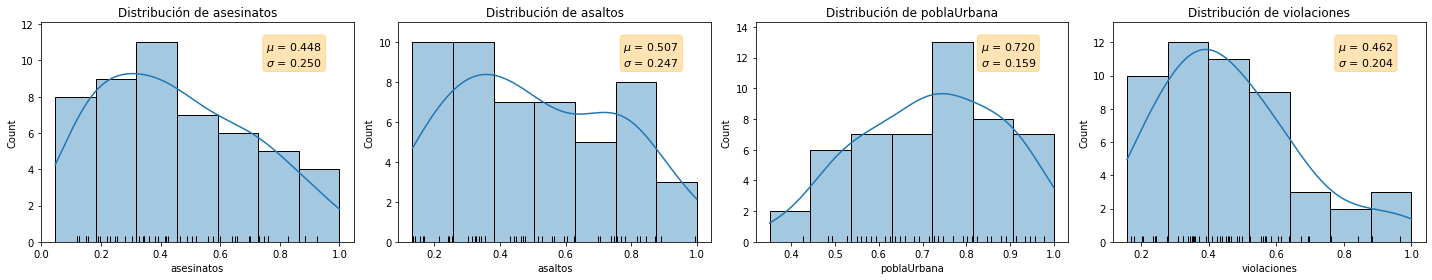

In [137]:
df_n = pd.DataFrame()
for col in df.columns:
    df_n[col] = normalizacion(df[col])
print("Aplicando normalizacion: ")
print_dataset(df_n, 1, 4)

Aplicando estandarizacion: 


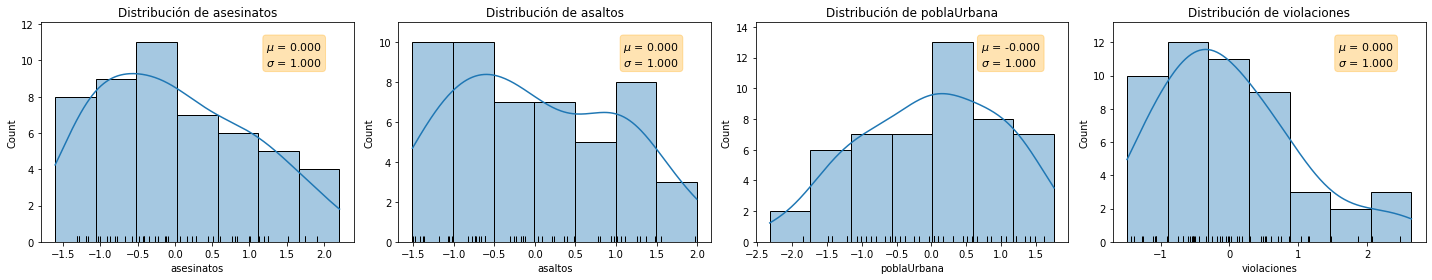

In [138]:
df_e = pd.DataFrame()
for col in df.columns:
    df_e[col] = estandarizacion(df[col])
print("Aplicando estandarizacion: ")
print_dataset(df_e, 1, 4)

Aplicando normalizacion l1: 


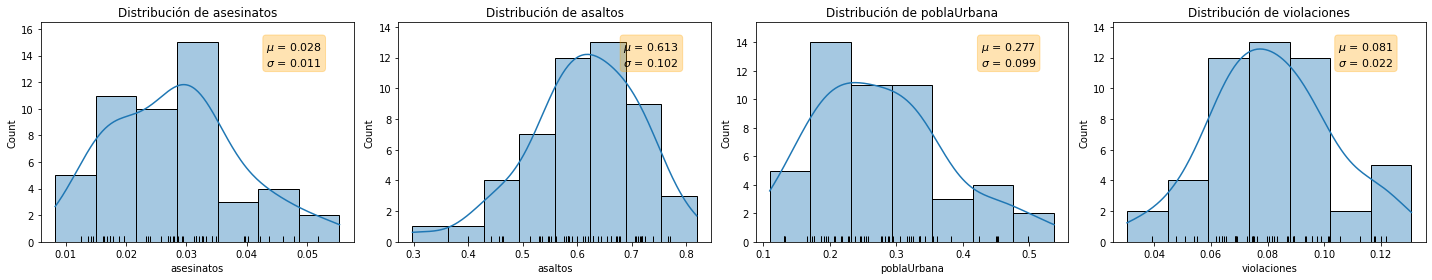

In [139]:
df_l1 = normalize(df, norm="l1")
df_l1 = pd.DataFrame(df_l1, columns = df.columns)
print("Aplicando normalizacion l1: ")
print_dataset(df_l1, 1, 4)

Aplicando normalizacion l2: 


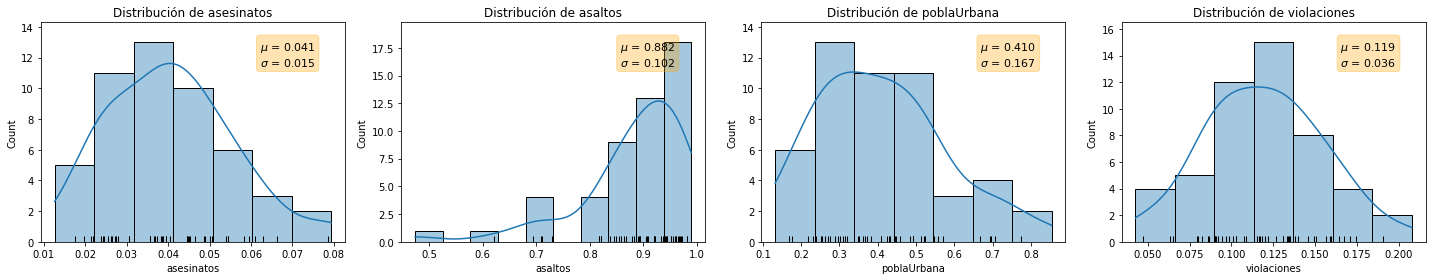

In [140]:
df_l2 = normalize(df, norm="l2")
df_l2 = pd.DataFrame(df_l2, columns = df.columns)
print("Aplicando normalizacion l2: ")
print_dataset(df_l2, 1, 4)

Aplicando normalizacion max: 


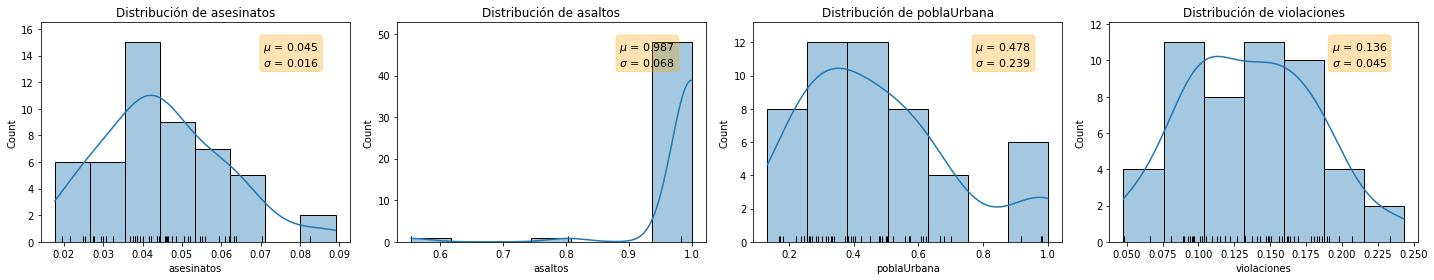

In [141]:
df_max = normalize(df, norm="max")
df_max = pd.DataFrame(df_max, columns = df.columns)
print("Aplicando normalizacion max: ")
print_dataset(df_max, 1, 4)

### Definicion de modelos

#### Funciones para la evaluación de los modelos

In [142]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluacion_modelo(df, labels):
    '''
        evaluacion_modelo:
            Funcion que devuelve dos los indices  de Silhoette y Davies Bouldin
            de una agrupacion de datos
    '''
    if labels.shape[0]>1:
        silhouette = silhouette_score(df,labels)
        davies_bouldin = davies_bouldin_score(df,labels)
    else:
        silhouette = -1
        davies_bouldin = 80
    return (silhouette, davies_bouldin)

def buscar_optimo(conjunto):
    '''
        buscar_optimo:
            Utilizando la funcion evaluacion_modelo devuelve el modelo con mejores
            métricas y realiza un pequeño informe del mismo

            Parametro:
                conjunto = list(
                    DataFrame utilizado (pd.DataFrame), 
                    modelo de clustering (sklearn.cluster), 
                    metricas obtenidas (list(silhouette,davies_bouldin)), 
                    nombre del modelo (str)
                )
            Devuelve:
                df_op: una copia del DataFrame utilizado
                model: modelo de clustering óptimo
    '''
    i_op = 0
    sl_op = -1
    db_op = 80
    for i in range(len(conjunto)):
        if conjunto[i][2][0]>sl_op and conjunto[i][2][1]<db_op:
            i_op = i
            sl_op = conjunto[i][2][0]
            db_op = conjunto[i][2][1]

    df_op = pd.DataFrame.copy(conjunto[i_op][0])
    model = conjunto[i_op][1]

    print("DataFrame optimo:",conjunto[i_op][-1])
    print("Modelo optimo:",model)
    print("Cantidad de clusters:",np.max(model.labels_)+1)
    print("Metricas:")
    print(f"-- Indice de Silhuette (ideal 1): {sl_op:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {db_op:.3f}")

    return df_op, model

def print_clusters(df, model, name_model):
    '''
        print_clusters:
            Imprime el ScatterPlot del DataFrame pasado por parámetro
            Pinta con colores los Clusters identificados por el modelo
    '''
    df["name_model"] = model.labels_
    df[name_model+"_cluster"] = model.labels_
    sns.pairplot(data = df, hue="name_model")
    df = df.drop("name_model",axis=1)
    df = df.drop(name_model+"_cluster",axis=1)

#### KMeans

In [143]:
from sklearn.cluster import KMeans

def kmeans_model(df):
    optimo = []
    metricas_optimo = [-1, 80]
    for i in range(2, int(np.sqrt(df.shape[0]))):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(df)
        metricas = evaluacion_modelo(df, kmeans.labels_)
        if metricas[0]>metricas_optimo[0] and metricas[1]<metricas_optimo[1]:
            optimo = kmeans
            metricas_optimo = metricas
    print("Modelo: ", optimo)
    print("Metricas:")
    print(f"-- Indice de Silhuette (ideal 1): {metricas_optimo[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas_optimo[1]:.3f}")
    return optimo, metricas_optimo

##### Algoritmo con el dataset en sus distintas escalas

In [144]:
conjunto = []

In [145]:
kmeans, metricas = kmeans_model(df)
conjunto.append((df,kmeans,metricas,"df"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.593
-- Indice de Davies Bouldin (mejor menor): 0.524


In [146]:
kmeans, metricas = kmeans_model(df_n)
conjunto.append((df,kmeans,metricas,"df_n"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.465
-- Indice de Davies Bouldin (mejor menor): 0.828


In [147]:
kmeans, metricas = kmeans_model(df_e)
conjunto.append((df,kmeans,metricas,"df_le"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.408
-- Indice de Davies Bouldin (mejor menor): 0.970


In [148]:
kmeans, metricas = kmeans_model(df_l1)
conjunto.append((df,kmeans,metricas,"df_l1"))

Modelo:  KMeans(n_clusters=3, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.532
-- Indice de Davies Bouldin (mejor menor): 0.567


In [149]:
kmeans, metricas = kmeans_model(df_l2)
conjunto.append((df,kmeans,metricas,"df_l2"))

Modelo:  KMeans(n_clusters=3, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.543
-- Indice de Davies Bouldin (mejor menor): 0.563


In [150]:
kmeans, metricas = kmeans_model(df_max)
conjunto.append((df,kmeans,metricas,"df_max"))

Modelo:  KMeans(n_clusters=3, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.551
-- Indice de Davies Bouldin (mejor menor): 0.569


##### Mejor modelo junto a su dataset asociado

DataFrame optimo: df
Modelo optimo: KMeans(n_clusters=2, random_state=0)
Cantidad de clusters: 2
Metricas:
-- Indice de Silhuette (ideal 1): 0.593
-- Indice de Davies Bouldin (mejor menor): 0.524


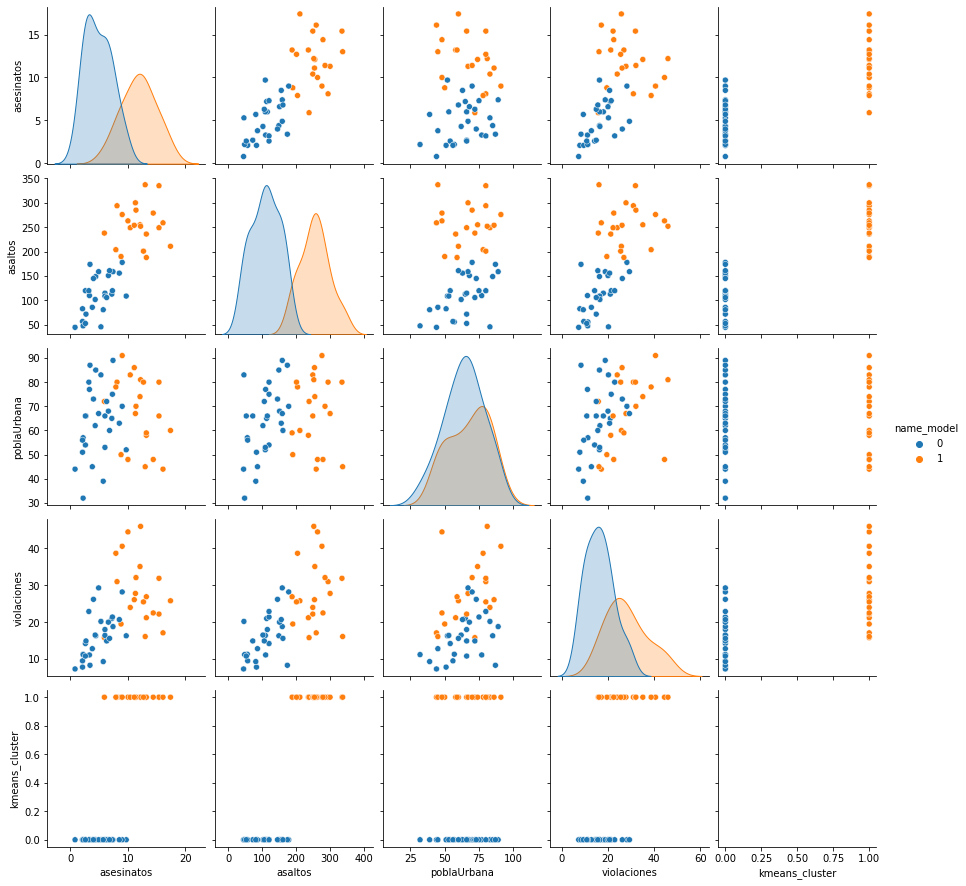

In [151]:
df_op, kmeans = buscar_optimo(conjunto)
print_clusters(df_op, kmeans, "kmeans")

#### Mean shift

In [152]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift_model(df):
    bandwidth = estimate_bandwidth(df, quantile=0.3)
    # ms = MeanShift(bandwidth=bandwidth,bin_seeding=True, n_jobs=4)
    ms = MeanShift(bandwidth=bandwidth)
    # ms = MeanShift(bin_seeding=True)
    # ms = MeanShift()
    ms.fit(df)

    metricas = evaluacion_modelo(df, ms.labels_)
    print("Modelo: ", ms)
    print("Metricas: ")
    print(f"-- Indice de Silhuette (ideal 1): {metricas[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas[1]:.3f}")
    return ms, metricas

##### Algoritmo con el dataset en sus distintas escalas

In [153]:
conjunto = []

In [154]:
ms, metricas = mean_shift_model(df)
conjunto.append((df,ms,metricas,"df"))

Modelo:  MeanShift(bandwidth=51.770332099055985)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.511
-- Indice de Davies Bouldin (mejor menor): 0.611


In [155]:
ms, metricas = mean_shift_model(df_n)
conjunto.append((df,ms,metricas,"df_n"))

Modelo:  MeanShift(bandwidth=0.38927737549859914)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.465
-- Indice de Davies Bouldin (mejor menor): 0.828


In [156]:
ms, metricas = mean_shift_model(df_e)
conjunto.append((df,ms,metricas,"df_le"))

Modelo:  MeanShift(bandwidth=1.9036598311393156)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.254
-- Indice de Davies Bouldin (mejor menor): 0.987


In [157]:
ms, metricas = mean_shift_model(df_l1)
conjunto.append((df,ms,metricas,"df_l1"))

Modelo:  MeanShift(bandwidth=0.09496581515614817)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.498
-- Indice de Davies Bouldin (mejor menor): 0.455


In [158]:
ms, metricas = mean_shift_model(df_l2)
conjunto.append((df,ms,metricas,"df_l2"))

Modelo:  MeanShift(bandwidth=0.12791194478128404)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.531
-- Indice de Davies Bouldin (mejor menor): 0.434


In [159]:
ms, metricas = mean_shift_model(df_max)
conjunto.append((df,ms,metricas,"df_max"))

Modelo:  MeanShift(bandwidth=0.1596538701934345)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.471
-- Indice de Davies Bouldin (mejor menor): 0.536


##### Mejor modelo junto a su dataset asociado

DataFrame optimo: df_l2
Modelo optimo: MeanShift(bandwidth=0.12791194478128404)
Cantidad de clusters: 4
Metricas:
-- Indice de Silhuette (ideal 1): 0.531
-- Indice de Davies Bouldin (mejor menor): 0.434


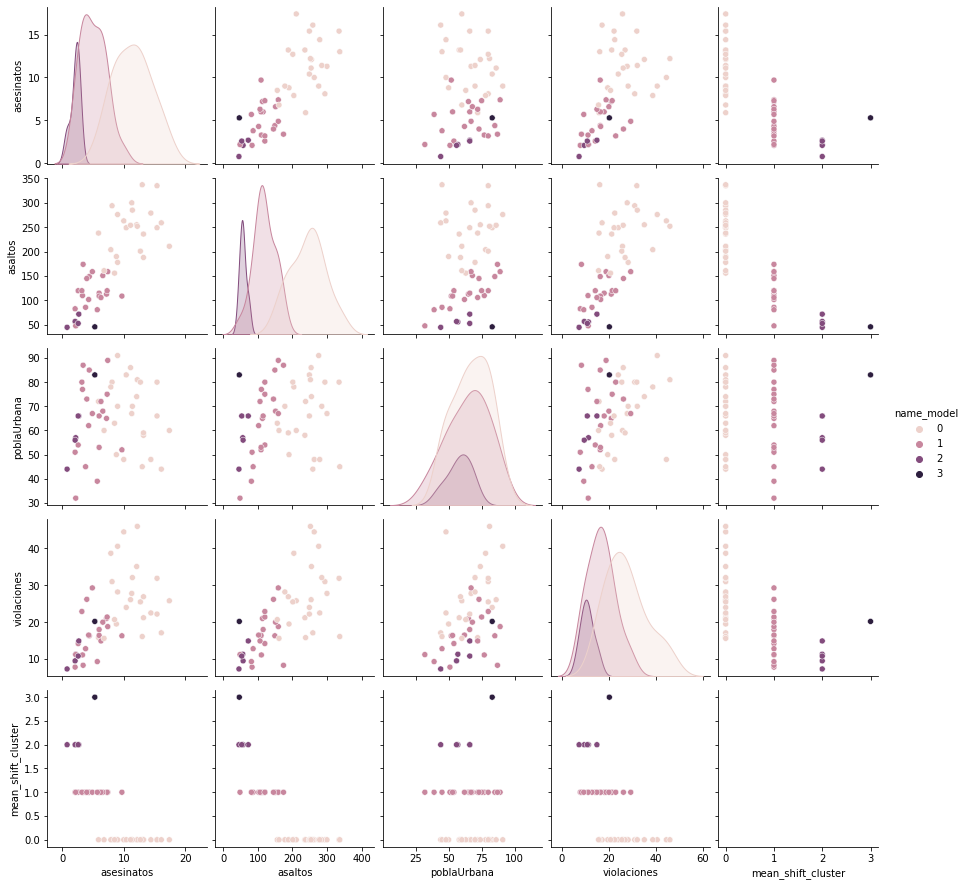

In [160]:
df_op, ms = buscar_optimo(conjunto)
print_clusters(df_op, ms, "mean_shift")

#### Affinity Propagation

In [161]:
from sklearn.cluster import AffinityPropagation

def affinity_propagation_model(df):
    # ap = AffinityPropagation(random_state=5)
    ap = AffinityPropagation()
    ap.fit(df)
    metricas = evaluacion_modelo(df, ap.labels_)
    print("Modelo: ", ap)
    print("Metricas: ")
    print(f"-- Indice de Silhuette (ideal 1): {metricas[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas[1]:.3f}")
    return ap, metricas

##### Algoritmo con el dataset en sus distintas escalas

In [162]:
conjunto = []

In [163]:
ap, metricas = affinity_propagation_model(df)
conjunto.append((df,ap,metricas,"df"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.432
-- Indice de Davies Bouldin (mejor menor): 0.719


In [164]:
ap, metricas = affinity_propagation_model(df_n)
conjunto.append((df,ap,metricas,"df_n"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.305
-- Indice de Davies Bouldin (mejor menor): 1.120


In [165]:
ap, metricas = affinity_propagation_model(df_e)
conjunto.append((df,ap,metricas,"df_le"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.311
-- Indice de Davies Bouldin (mejor menor): 1.033


In [166]:
ap, metricas = affinity_propagation_model(df_l1)
conjunto.append((df,ap,metricas,"df_l1"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.430
-- Indice de Davies Bouldin (mejor menor): 0.555


In [167]:
ap, metricas = affinity_propagation_model(df_l2)
conjunto.append((df,ap,metricas,"df_l2"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.385
-- Indice de Davies Bouldin (mejor menor): 0.641


In [168]:
ap, metricas = affinity_propagation_model(df_max)
conjunto.append((df,ap,metricas,"df_max"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.486
-- Indice de Davies Bouldin (mejor menor): 0.507


##### Mejor modelo junto a su dataset asociado

DataFrame optimo: df_max
Modelo optimo: AffinityPropagation()
Cantidad de clusters: 5
Metricas:
-- Indice de Silhuette (ideal 1): 0.486
-- Indice de Davies Bouldin (mejor menor): 0.507


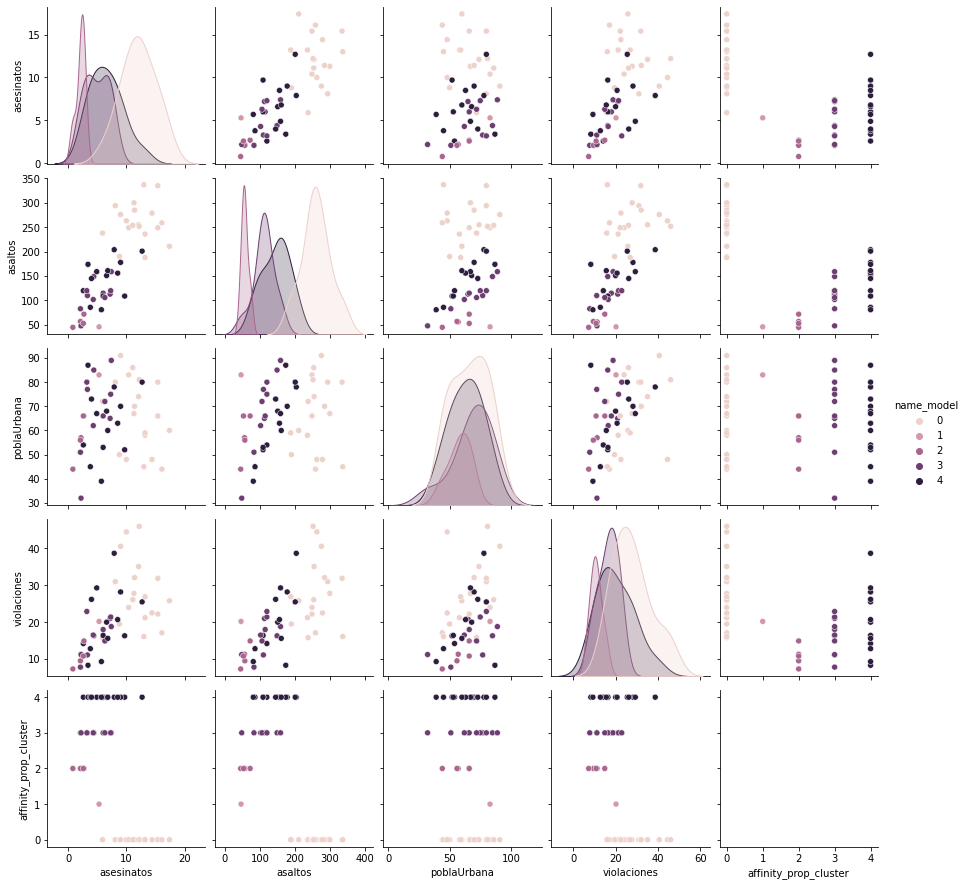

In [169]:
df_op, ap = buscar_optimo(conjunto)
print_clusters(df_op, ap, "affinity_prop")

#### Agglomerative Clustering

In [170]:
from sklearn.cluster import AgglomerativeClustering

def agglomerative_clustering_model(df):
    optimo = []
    metricas_optimo = [-1, 80]
    for i in range(2, int(np.sqrt(df.shape[0]))):
        ac = AgglomerativeClustering(n_clusters=i)
        ac.fit(df)
        metricas = evaluacion_modelo(df, ac.labels_)
        if metricas[0]>metricas_optimo[0] and metricas[1]<metricas_optimo[1]:
            optimo = ac
            metricas_optimo = metricas
    print("Modelo: ", optimo)
    print("Metricas:")
    print(f"-- Indice de Silhuette (ideal 1): {metricas_optimo[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas_optimo[1]:.3f}")
    return optimo, metricas_optimo

##### Algoritmo con el dataset en sus distintas escalas

In [171]:
conjunto = []

In [172]:
ac, metricas = agglomerative_clustering_model(df)
conjunto.append((df,ac,metricas,"df"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.576
-- Indice de Davies Bouldin (mejor menor): 0.512


In [173]:
ac, metricas = agglomerative_clustering_model(df_n)
conjunto.append((df,ac,metricas,"df_n"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.465
-- Indice de Davies Bouldin (mejor menor): 0.828


In [174]:
ac, metricas = agglomerative_clustering_model(df_e)
conjunto.append((df,ac,metricas,"df_le"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.405
-- Indice de Davies Bouldin (mejor menor): 0.980


In [175]:
ac, metricas = agglomerative_clustering_model(df_l1)
conjunto.append((df,ac,metricas,"df_l1"))

Modelo:  AgglomerativeClustering(n_clusters=3)
Metricas:
-- Indice de Silhuette (ideal 1): 0.532
-- Indice de Davies Bouldin (mejor menor): 0.567


In [176]:
ac, metricas = agglomerative_clustering_model(df_l2)
conjunto.append((df,ac,metricas,"df_l2"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.604
-- Indice de Davies Bouldin (mejor menor): 0.481


In [177]:
ac, metricas = agglomerative_clustering_model(df_max)
conjunto.append((df,ac,metricas,"df_max"))

Modelo:  AgglomerativeClustering(n_clusters=3)
Metricas:
-- Indice de Silhuette (ideal 1): 0.542
-- Indice de Davies Bouldin (mejor menor): 0.570


##### Mejor modelo junto a su dataset asociado

DataFrame optimo: df_l2
Modelo optimo: AgglomerativeClustering()
Cantidad de clusters: 2
Metricas:
-- Indice de Silhuette (ideal 1): 0.604
-- Indice de Davies Bouldin (mejor menor): 0.481


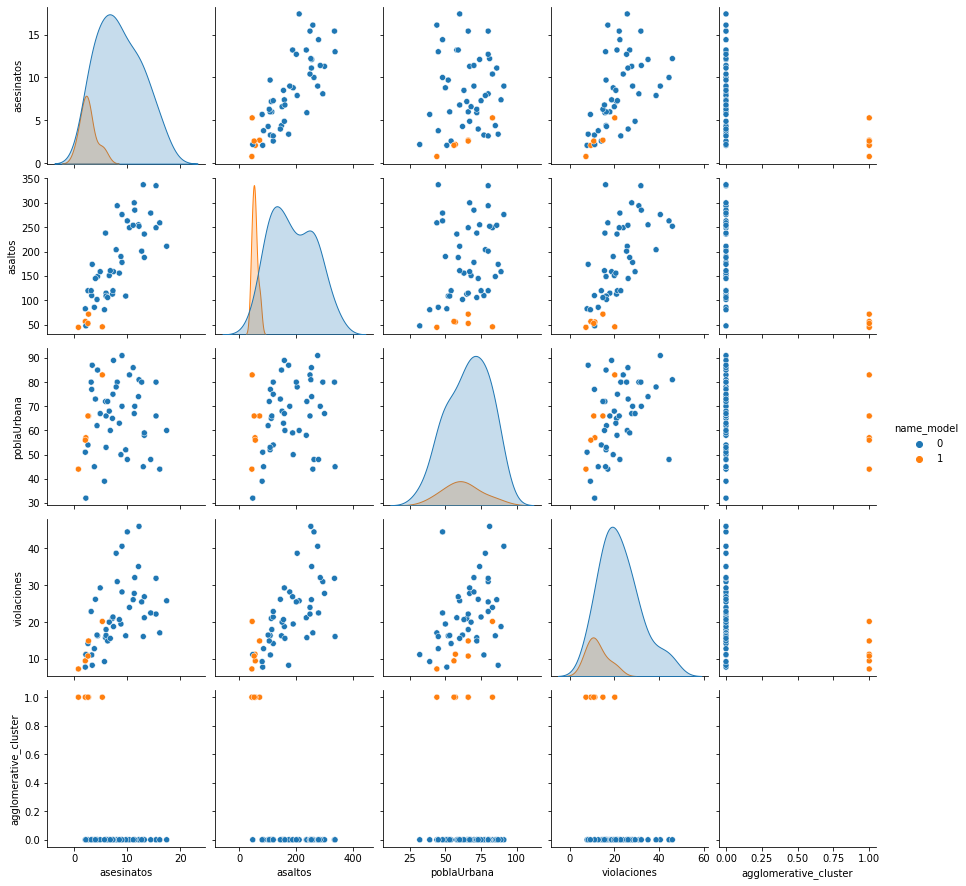

In [178]:
df_op, ac = buscar_optimo(conjunto)
print_clusters(df_op, ac, "agglomerative")

### Analisis de la mejor agrupacion de datos

Como se puede observar, los modelos óptimos de cada uno de los algoritmos difiere en la cantidad de clusters que se deben establecer. Sin embargo, los modelos de KMeans y AgglomerativeClustering obtienen mejores métricas utilizando solo dos clusters.

Dado que AgglomerativeClustering resultó ligeramente mejor que KMeans, en esta sección se analiza el agrupamiento realizado por el mismo.

In [179]:
# si bien se ha realizado el clustering sobre df_l2
# pretendo analizar el agrupamiento en los datos originales
df_op = pd.DataFrame.copy(df) 
df_op['label'] = ac.labels_

df_op = df_op.set_index(df.index)

In [180]:
df_op[(df_op['label']==0)]

,asesinatos,asaltos,poblaUrbana,violaciones,label
state,,,,,
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,0
Arizona,8.1,294,80,31.0,0
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,0
Colorado,7.9,204,78,38.7,0
Connecticut,3.3,110,77,11.1,0
Delaware,5.9,238,72,15.8,0
Florida,15.4,335,80,31.9,0


In [181]:
df_op[(df_op['label']==0)].describe().T

,count,mean,std,min,25%,50%,75%,max
asesinatos,44.0,8.493182,4.137936,2.1,5.50,8.0,11.575,17.4
asaltos,44.0,186.568182,75.975026,48.0,118.75,176.0,252.500,337.0
poblaUrbana,44.0,66.022727,14.724586,32.0,53.75,67.0,78.500,91.0
violaciones,44.0,22.445455,9.217740,7.8,16.25,21.1,27.125,46.0
label,44.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


In [182]:
df_op[(df_op['label']==1)]

,asesinatos,asaltos,poblaUrbana,violaciones,label
state,,,,,
Hawaii,5.3,46,83,20.2,1
Iowa,2.2,56,57,11.3,1
Minnesota,2.7,72,66,14.9,1
New Hampshire,2.1,57,56,9.5,1
North Dakota,0.8,45,44,7.3,1
Wisconsin,2.6,53,66,10.8,1


In [183]:
df_op[(df_op['label']==1)].describe().T

,count,mean,std,min,25%,50%,75%,max
asesinatos,6.0,2.616667,1.479752,0.8,2.125,2.40,2.675,5.3
asaltos,6.0,54.833333,9.786044,45.0,47.750,54.50,56.750,72.0
poblaUrbana,6.0,62.000000,13.099618,44.0,56.250,61.50,66.000,83.0
violaciones,6.0,12.333333,4.588101,7.3,9.825,11.05,14.000,20.2
label,6.0,1.000000,0.000000,1.0,1.000,1.00,1.000,1.0


**Conclusión:** a pesar de no obtener las mejores métricas, se puede ver que el algoritmo ha diferenciado entre dos grupos de estados. Uno bastante grande de 44 estados (cluster 0) y otro de solo 6 estados (cluster 1). Los primeros están caracterizados por tener indices de violencia más altos en comparación de los estados más "tranquilos".

Es posible ver también que el indice promedio de población urbana es apenas menor en los "tranquilos", por lo que no significaría un indicador de violencia.

## Extender dataset

En https://corgis-edu.github.io/corgis/csv/state_crime/ se presenta un dataset más extenso con una descripción por año en cada Estado desde 1960 a 2019.

In [186]:
tabla = pd.read_html("https://corgis-edu.github.io/corgis/csv/state_crime/")[0]
print("Especificaciones del dataset")
tabla

Especificaciones del dataset


,Key,List of...,Comment,Example Value
0,State,String,The long name of the state that this report wa...,"""Alabama"""
1,Year,Integer,The year that this report was made in.,1960
2,Data.Population,Integer,The number of people living in this state at t...,3266740
3,Data.Rates.Property.All,Float,Rates are the number of reported offenses per ...,1035.4
4,Data.Rates.Property.Burglary,Float,Rates are the number of reported offenses per ...,355.9
5,Data.Rates.Property.Larceny,Float,Rates are the number of reported offenses per ...,592.1
6,Data.Rates.Property.Motor,Float,Rates are the number of reported offenses per ...,87.3
7,Data.Rates.Violent.All,Float,Rates are the number of reported offenses per ...,186.6
8,Data.Rates.Violent.Assault,Float,Rates are the number of reported offenses per ...,138.1
9,Data.Rates.Violent.Murder,Float,Rates are the number of reported offenses per ...,12.4


### Carga del dataset


In [203]:
!wget https://corgis-edu.github.io/corgis/datasets/csv/state_crime/state_crime.csv

--2022-06-02 15:27:37--  https://corgis-edu.github.io/corgis/datasets/csv/state_crime/state_crime.csv
Resolving corgis-edu.github.io (corgis-edu.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to corgis-edu.github.io (corgis-edu.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 515354 (503K) [text/csv]
Saving to: ‘state_crime.csv’

state_crime.csv     100%[===================>] 503.28K  --.-KB/s    in 0.004s  

2022-06-02 15:27:37 (117 MB/s) - ‘state_crime.csv’ saved [515354/515354]



In [204]:
df = pd.read_csv("/content/state_crime.csv")
df.head()

,State,Year,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,...,Data.Rates.Violent.Robbery,Data.Totals.Property.All,Data.Totals.Property.Burglary,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery
0,Alabama,1960,3266740,1035.4,355.9,592.1,87.3,186.6,138.1,12.4,...,27.5,33823,11626,19344,2853,6097,4512,406,281,898
1,Alabama,1961,3302000,985.5,339.3,569.4,76.8,168.5,128.9,12.9,...,19.1,32541,11205,18801,2535,5564,4255,427,252,630
2,Alabama,1962,3358000,1067.0,349.1,634.5,83.4,157.3,119.0,9.4,...,22.5,35829,11722,21306,2801,5283,3995,316,218,754
3,Alabama,1963,3347000,1150.9,376.9,683.4,90.6,182.7,142.1,10.2,...,24.7,38521,12614,22874,3033,6115,4755,340,192,828
4,Alabama,1964,3407000,1358.7,466.6,784.1,108.0,213.1,163.0,9.3,...,29.1,46290,15898,26713,3679,7260,5555,316,397,992


In [205]:
columnas_que_quedan = ["Data.Rates.Violent.Assault", "Data.Rates.Violent.Murder", "Data.Rates.Violent.Rape","Data.Rates.Violent.Robbery"]
columnas_que_se_van = ["Year"] #df.columns.drop(columnas_que_quedan)
df = df.drop(columnas_que_se_van, axis=1)
df = df.set_index(df['State']).drop('State', axis=1)
df.head()

,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,Data.Rates.Violent.Rape,Data.Rates.Violent.Robbery,Data.Totals.Property.All,Data.Totals.Property.Burglary,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery
State,,,,,,,,,,,,,,,,,,,
Alabama,3266740,1035.4,355.9,592.1,87.3,186.6,138.1,12.4,8.6,27.5,33823,11626,19344,2853,6097,4512,406,281,898
Alabama,3302000,985.5,339.3,569.4,76.8,168.5,128.9,12.9,7.6,19.1,32541,11205,18801,2535,5564,4255,427,252,630
Alabama,3358000,1067.0,349.1,634.5,83.4,157.3,119.0,9.4,6.5,22.5,35829,11722,21306,2801,5283,3995,316,218,754
Alabama,3347000,1150.9,376.9,683.4,90.6,182.7,142.1,10.2,5.7,24.7,38521,12614,22874,3033,6115,4755,340,192,828
Alabama,3407000,1358.7,466.6,784.1,108.0,213.1,163.0,9.3,11.7,29.1,46290,15898,26713,3679,7260,5555,316,397,992


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3115 entries, Alabama to Wyoming
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Data.Population                3115 non-null   int64  
 1   Data.Rates.Property.All        3115 non-null   float64
 2   Data.Rates.Property.Burglary   3115 non-null   float64
 3   Data.Rates.Property.Larceny    3115 non-null   float64
 4   Data.Rates.Property.Motor      3115 non-null   float64
 5   Data.Rates.Violent.All         3115 non-null   float64
 6   Data.Rates.Violent.Assault     3115 non-null   float64
 7   Data.Rates.Violent.Murder      3115 non-null   float64
 8   Data.Rates.Violent.Rape        3115 non-null   float64
 9   Data.Rates.Violent.Robbery     3115 non-null   float64
 10  Data.Totals.Property.All       3115 non-null   int64  
 11  Data.Totals.Property.Burglary  3115 non-null   int64  
 12  Data.Totals.Property.Larceny   3115 non-null

Se hace un resumen para todos los años disponibles por Estado

In [207]:
df_final = pd.DataFrame(columns=df.columns.values)
for col in df.columns.values:
    temp = df[col].groupby('State')
    df_final[col] = temp.mean()
df_final.head()

,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,Data.Rates.Violent.Rape,Data.Rates.Violent.Robbery,Data.Totals.Property.All,Data.Totals.Property.Burglary,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery
State,,,,,,,,,,,,,,,,,,,
Alabama,4.111466e+06,3108.880000,1039.531667,2011.065000,349.613333,440.486667,288.883333,10.140000,27.590000,100.423333,1.298127e+05,43887.466667,84777.050000,15267.083333,18508.666667,12042.300000,406.483333,1178.900000,4228.216667
Alaska,5.152013e+05,3803.965000,893.748333,2602.383333,554.825000,525.123333,344.173333,8.543333,69.041667,84.833333,1.938970e+04,4709.383333,13518.016667,2981.933333,3019.533333,1973.850000,40.750000,402.383333,466.000000
Arizona,3.948484e+06,5149.128333,1422.648333,3362.785000,658.786667,482.733333,303.356667,7.321667,34.483333,126.280000,1.879100e+05,53954.133333,124158.300000,29642.100000,19911.033333,12404.283333,282.000000,1471.150000,4993.700000
Arkansas,2.422008e+06,2989.780000,1009.048333,1985.863333,307.415000,393.780000,262.213333,8.080000,33.650000,74.183333,7.409852e+04,25612.366667,49555.383333,8206.116667,10001.683333,6635.716667,192.033333,872.050000,1837.100000
California,2.855579e+07,4359.176667,1329.713333,2567.741667,685.923333,617.291667,339.663333,7.890000,34.218333,224.545000,1.163731e+06,358082.783333,691070.750000,201472.483333,178274.266667,99361.366667,2207.500000,9654.166667,62802.366667


In [208]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, Alabama to Wyoming
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Data.Population                52 non-null     float64
 1   Data.Rates.Property.All        52 non-null     float64
 2   Data.Rates.Property.Burglary   52 non-null     float64
 3   Data.Rates.Property.Larceny    52 non-null     float64
 4   Data.Rates.Property.Motor      52 non-null     float64
 5   Data.Rates.Violent.All         52 non-null     float64
 6   Data.Rates.Violent.Assault     52 non-null     float64
 7   Data.Rates.Violent.Murder      52 non-null     float64
 8   Data.Rates.Violent.Rape        52 non-null     float64
 9   Data.Rates.Violent.Robbery     52 non-null     float64
 10  Data.Totals.Property.All       52 non-null     float64
 11  Data.Totals.Property.Burglary  52 non-null     float64
 12  Data.Totals.Property.Larceny   52 non-null    

In [209]:
df_final.index

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'United States', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object', name='State')

In [210]:
df_final = df_final.drop('United States') # Se elimina dado que tiene la informacion de todo el pais

### Algoritmos de Clustering

En este caso solo se aplicarán los algoritmos al dataset sin modificar

In [211]:
conjunto = []

In [212]:
kmeans, metricas = kmeans_model(df_final)
conjunto.append((df_final,kmeans,metricas,"df_final"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.736
-- Indice de Davies Bouldin (mejor menor): 0.516


In [213]:
ms, metricas = mean_shift_model(df_final)
conjunto.append((df_final,ms,metricas,"df_final"))

Modelo:  MeanShift(bandwidth=2676295.3911047573)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.637
-- Indice de Davies Bouldin (mejor menor): 0.353


In [214]:
ap, metricas = affinity_propagation_model(df_final)
conjunto.append((df_final,ap,metricas,"df_final"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.614
-- Indice de Davies Bouldin (mejor menor): 0.348


In [215]:
ac, metricas = agglomerative_clustering_model(df_final)
conjunto.append((df_final,ac,metricas,"df_final"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.736
-- Indice de Davies Bouldin (mejor menor): 0.516


### Analisis de la mejor agrupacion de datos

El modelo óptimo seleccionado es el de KMeans, aunque AgglomerativeClustering obtuvo las mismas métricas.

DataFrame optimo: df_final
Modelo optimo: KMeans(n_clusters=2, random_state=0)
Cantidad de clusters: 2
Metricas:
-- Indice de Silhuette (ideal 1): 0.736
-- Indice de Davies Bouldin (mejor menor): 0.516


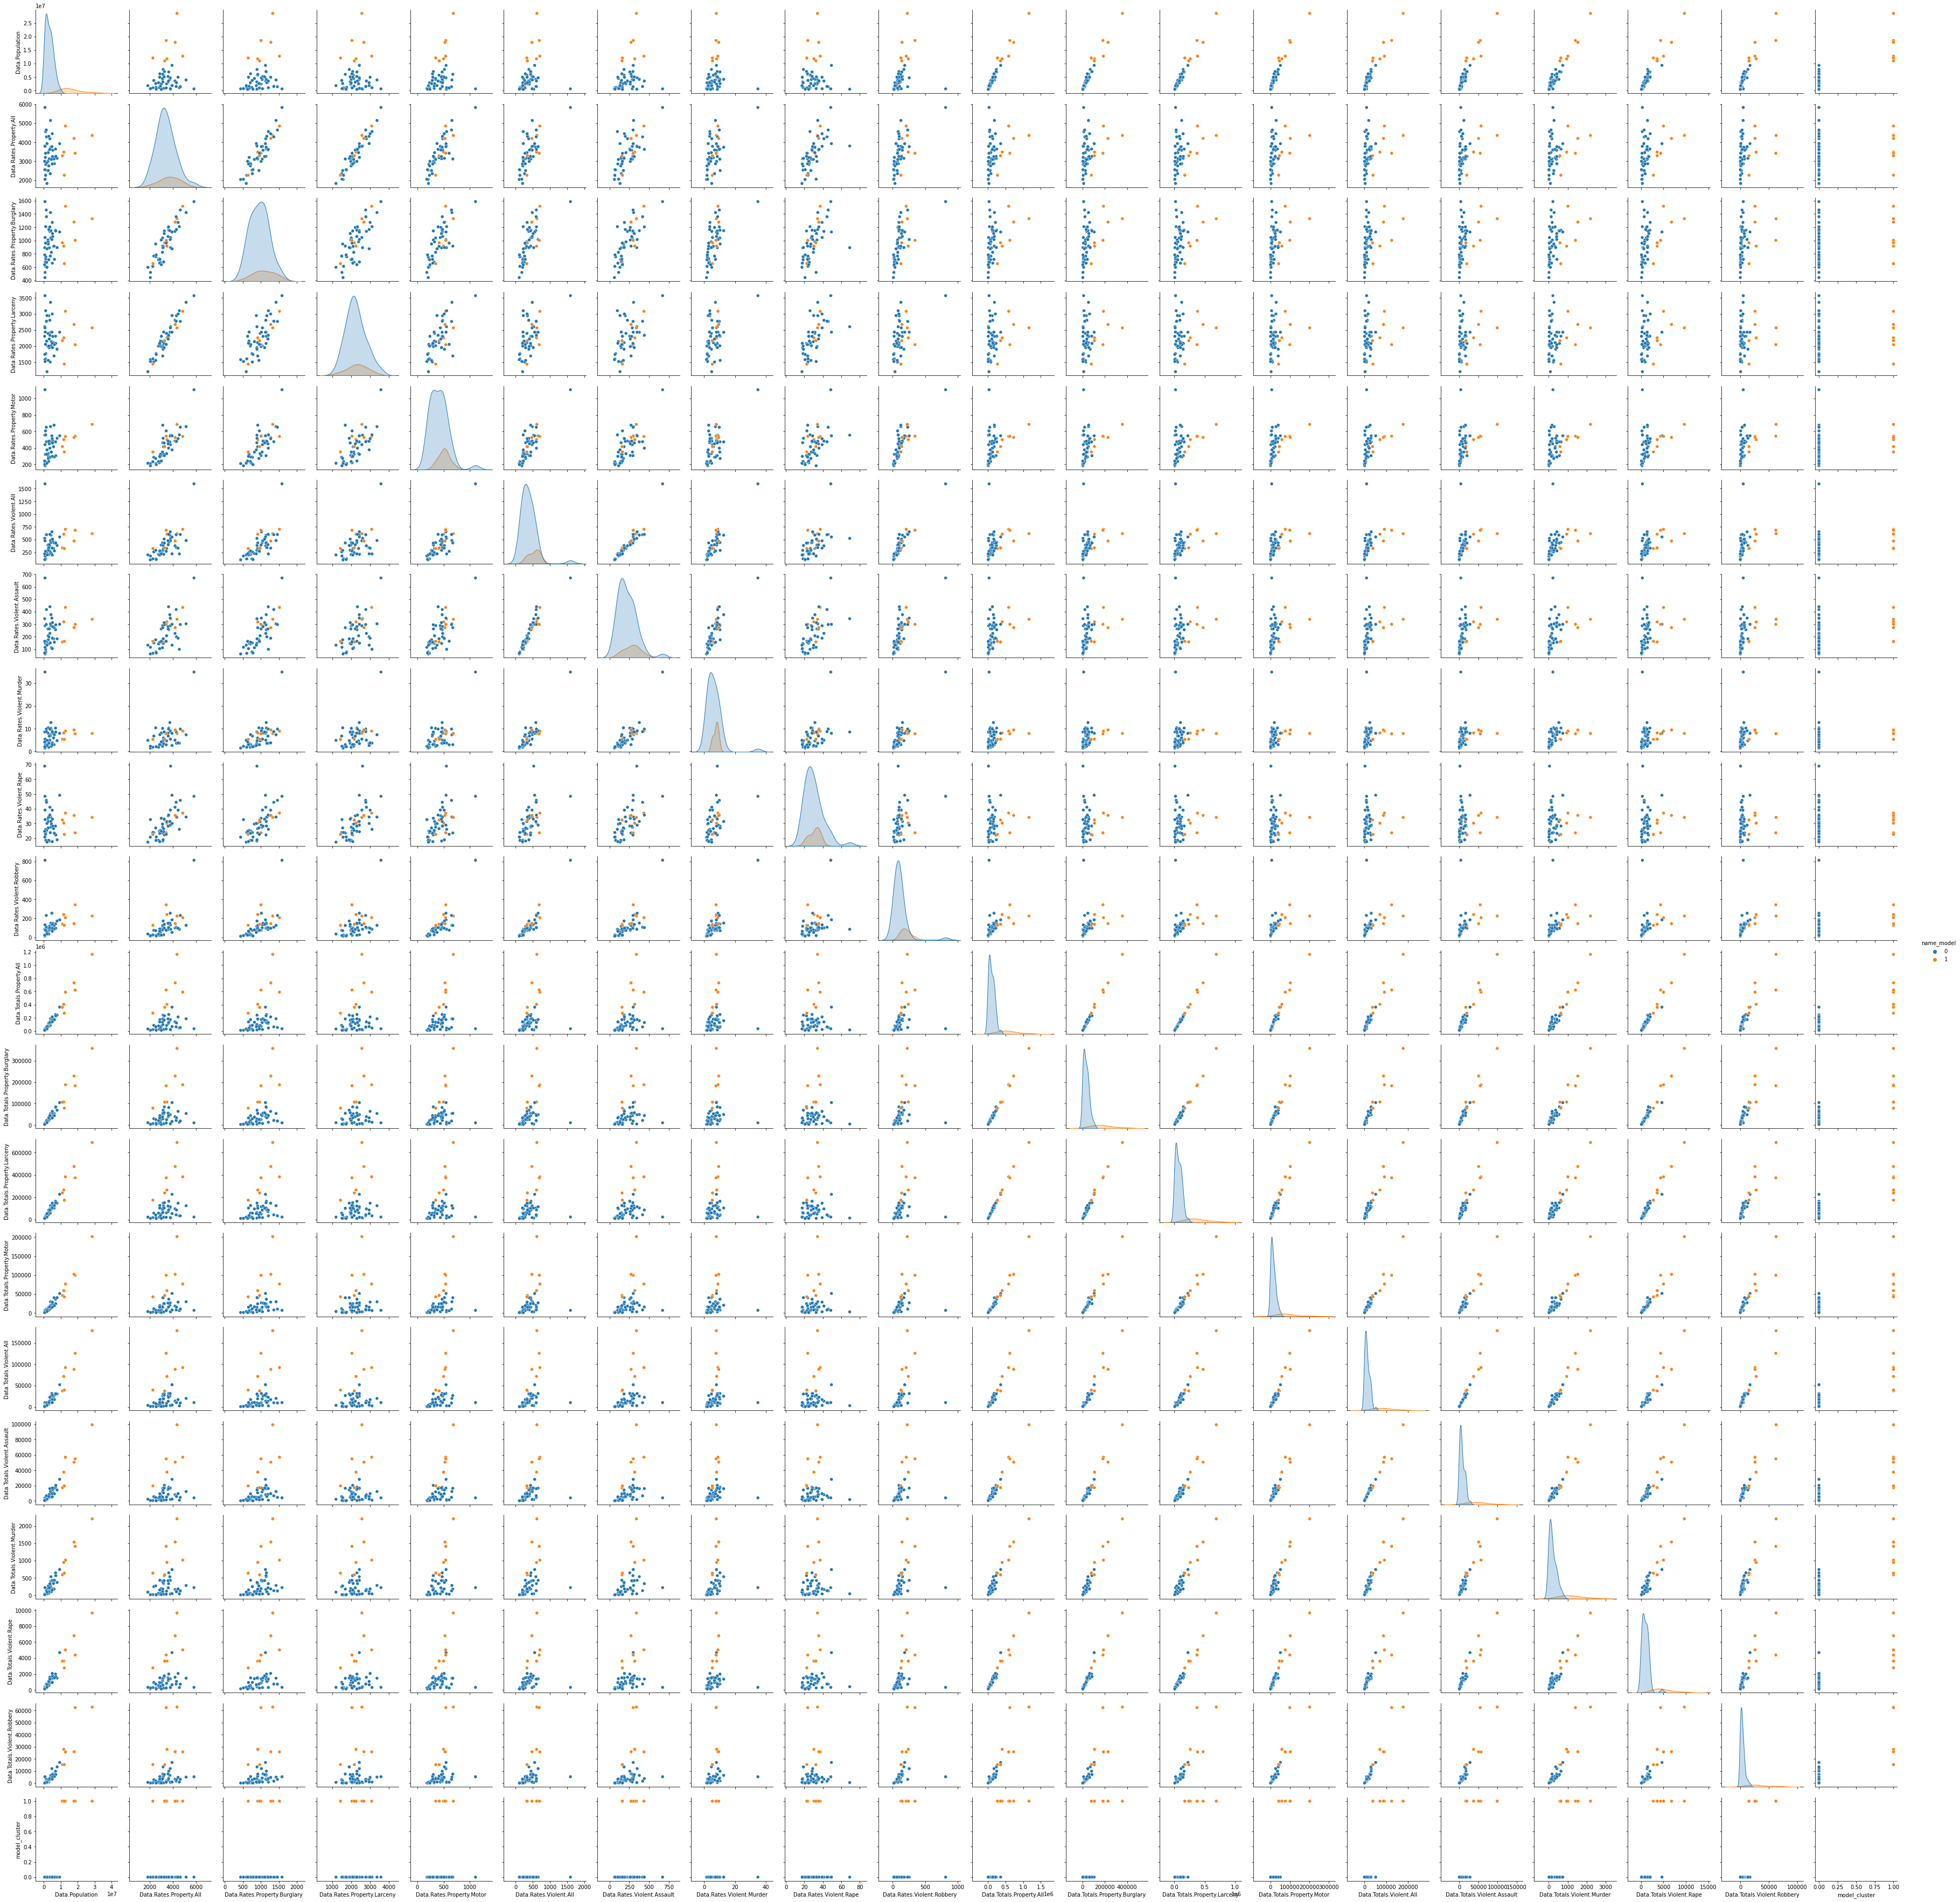

In [216]:
df_op, model_optimo = buscar_optimo(conjunto)
print_clusters(df_op, model_optimo, "model")
df_op['label'] = model_optimo.labels_

In [217]:
df_op[(df_op['label']==0)]

,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,Data.Rates.Violent.Rape,Data.Rates.Violent.Robbery,...,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery,name_model,model_cluster,label
State,,,,,,,,,,,,,,,,,,,,,
Alabama,4.111466e+06,3108.880000,1039.531667,2011.065000,349.613333,440.486667,288.883333,10.140000,27.590000,100.423333,...,84777.050000,15267.083333,18508.666667,12042.300000,406.483333,1178.900000,4228.216667,0,0,0
Alaska,5.152013e+05,3803.965000,893.748333,2602.383333,554.825000,525.123333,344.173333,8.543333,69.041667,84.833333,...,13518.016667,2981.933333,3019.533333,1973.850000,40.750000,402.383333,466.000000,0,0,0
Arizona,3.948484e+06,5149.128333,1422.648333,3362.785000,658.786667,482.733333,303.356667,7.321667,34.483333,126.280000,...,124158.300000,29642.100000,19911.033333,12404.283333,282.000000,1471.150000,4993.700000,0,0,0
Arkansas,2.422008e+06,2989.780000,1009.048333,1985.863333,307.415000,393.780000,262.213333,8.080000,33.650000,74.183333,...,49555.383333,8206.116667,10001.683333,6635.716667,192.033333,872.050000,1837.100000,0,0,0
Colorado,3.558561e+06,4187.023333,1138.688333,2803.923333,483.003333,378.951667,226.676667,4.936667,41.130000,98.586667,...,95714.700000,18384.333333,13687.400000,8253.116667,165.050000,1584.700000,3276.216667,0,0,0
Connecticut,3.230428e+06,3130.053333,891.141667,1951.168333,463.076667,290.211667,146.350000,3.555000,18.163333,116.756667,...,63112.166667,15126.200000,9536.616667,4813.316667,115.483333,601.716667,3812.666667,0,0,0
Delaware,6.963619e+05,3783.940000,1046.793333,2567.143333,438.770000,477.705000,287.613333,5.391667,39.226667,131.070000,...,17594.233333,3209.550000,3519.033333,2119.516667,36.600000,286.983333,941.033333,0,0,0
District of Columbia,6.556831e+05,5832.185000,1587.595000,3570.268333,1106.658333,1594.441667,670.598333,34.940000,48.563333,812.288333,...,22823.333333,7056.950000,10208.016667,4216.583333,219.916667,319.116667,5267.500000,0,0,0
Georgia,6.905492e+06,3640.823333,1156.578333,2308.886667,472.985000,445.606667,256.031667,10.268333,28.356667,141.225000,...,164216.033333,36370.850000,31531.683333,18035.700000,646.783333,1987.716667,9876.733333,0,0,0


In [218]:
df_op[(df_op['label']==0)].describe().T

,count,mean,std,min,25%,50%,75%,max
Data.Population,44.0,3.190390e+06,2.265389e+06,461218.533333,1.106715e+06,2.920865e+06,4.797317e+06,9.342703e+06
Data.Rates.Property.All,44.0,3.375778e+03,8.311186e+02,1828.458333,2.865300e+03,3.224480e+03,3.788946e+03,5.832185e+03
Data.Rates.Property.Burglary,44.0,9.609401e+02,2.621177e+02,443.643333,7.486833e+02,9.557000e+02,1.146348e+03,1.587595e+03
Data.Rates.Property.Larceny,44.0,2.244336e+03,5.178719e+02,1204.320000,1.952462e+03,2.146991e+03,2.470067e+03,3.570268e+03
Data.Rates.Property.Motor,44.0,4.129554e+02,1.745279e+02,182.875000,2.891729e+02,4.055042e+02,4.903892e+02,1.106658e+03
Data.Rates.Violent.All,44.0,3.749640e+02,2.413223e+02,103.571667,2.209367e+02,3.304425e+02,4.781017e+02,1.594442e+03
Data.Rates.Violent.Assault,44.0,2.211939e+02,1.185959e+02,61.975000,1.452350e+02,1.858092e+02,2.905537e+02,6.705983e+02
Data.Rates.Violent.Murder,44.0,6.299697e+00,5.340868e+00,1.468333,2.976250e+00,4.897500e+00,8.520833e+00,3.494000e+01
Data.Rates.Violent.Rape,44.0,3.005966e+01,1.028316e+01,17.426667,2.357833e+01,2.794500e+01,3.448417e+01,6.904167e+01
Data.Rates.Violent.Robbery,44.0,1.071932e+02,1.218770e+02,11.758333,5.382167e+01,8.642583e+01,1.253037e+02,8.122883e+02


In [219]:
df_op[(df_op['label']==1)]

,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,Data.Rates.Violent.Rape,Data.Rates.Violent.Robbery,...,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery,name_model,model_cluster,label
State,,,,,,,,,,,,,,,,,,,,,
California,2.855579e+07,4359.176667,1329.713333,2567.741667,685.923333,617.291667,339.663333,7.890000,34.218333,224.545000,...,691070.750000,201472.483333,178274.266667,99361.366667,2207.500000,9654.166667,62802.366667,1,1,1
Florida,1.275038e+07,4855.270000,1517.321667,3083.296667,539.340000,702.916667,434.508333,8.926667,37.146667,207.118333,...,383155.633333,76380.950000,92006.700000,57155.283333,1015.200000,5022.516667,25786.350000,1,1,1
Illinois,1.176214e+07,3484.205000,917.095000,2259.361667,501.070000,606.878333,318.750000,8.096667,30.323333,240.276667,...,265107.083333,58942.933333,71362.300000,37672.083333,948.416667,3608.450000,27920.416667,1,1,1
New York,1.853805e+07,3422.185455,1004.745455,2045.329091,542.454545,685.250909,299.361818,7.738182,23.716364,342.909091,...,374503.527273,99532.000000,125426.345455,55025.763636,1412.818182,4379.436364,62333.872727,1,1,1
Ohio,1.098335e+07,3289.910000,967.238333,2169.133333,416.376667,339.258333,158.141667,5.386667,32.468333,138.428333,...,238866.233333,46219.266667,37474.316667,17460.366667,590.500000,3617.650000,15245.000000,1,1,1
Pennsylvania,1.207616e+07,2264.040000,652.400000,1440.218333,350.946667,325.281667,162.855000,5.273333,22.680000,126.693333,...,174205.216667,42657.316667,39508.666667,19804.983333,638.433333,2766.083333,15303.600000,1,1,1
Texas,1.785551e+07,4201.310000,1278.870000,2673.811667,527.506667,472.520000,272.493333,9.445000,35.566667,144.256667,...,475772.333333,102155.050000,87850.600000,50725.900000,1538.283333,6791.483333,25894.766667,1,1,1


In [220]:
df_op[(df_op['label']==1)].describe().T

,count,mean,std,min,25%,50%,75%,max
Data.Population,7.0,1.607448e+07,6.279285e+06,1.098335e+07,1.191915e+07,1.275038e+07,1.819678e+07,2.855579e+07
Data.Rates.Property.All,7.0,3.696585e+03,8.538439e+02,2.264040e+03,3.356048e+03,3.484205e+03,4.280243e+03,4.855270e+03
Data.Rates.Property.Burglary,7.0,1.095341e+03,2.941845e+02,6.524000e+02,9.421667e+02,1.004745e+03,1.304292e+03,1.517322e+03
Data.Rates.Property.Larceny,7.0,2.319842e+03,5.236217e+02,1.440218e+03,2.107231e+03,2.259362e+03,2.620777e+03,3.083297e+03
Data.Rates.Property.Motor,7.0,5.090883e+02,1.059142e+02,3.509467e+02,4.587233e+02,5.275067e+02,5.408973e+02,6.859233e+02
Data.Rates.Violent.All,7.0,5.356282e+02,1.575369e+02,3.252817e+02,4.058892e+02,6.068783e+02,6.512713e+02,7.029167e+02
Data.Rates.Violent.Assault,7.0,2.836819e+02,9.818591e+01,1.581417e+02,2.176742e+02,2.993618e+02,3.292067e+02,4.345083e+02
Data.Rates.Violent.Murder,7.0,7.536645e+00,1.622656e+00,5.273333e+00,6.562424e+00,7.890000e+00,8.511667e+00,9.445000e+00
Data.Rates.Violent.Rape,7.0,3.087424e+01,5.682877e+00,2.268000e+01,2.701985e+01,3.246833e+01,3.489250e+01,3.714667e+01
Data.Rates.Violent.Robbery,7.0,2.034611e+02,7.625260e+01,1.266933e+02,1.413425e+02,2.071183e+02,2.324108e+02,3.429091e+02


**Conclusión:** En este caso se ha extendido la información en cuanto a indices de tasas de violencia y cantidades reales delitos. Por lo que los algortimos han contado con más información para agrupar y diferenciar estados.

Aunque nuevamente el modelo óptimo identifica 2 clusters, que pueden ser interpretados como estados más violentos (cluster 1) y por otro lado los menos violentos (cluster 0). 

De la misma manera que antes se obtuvo un grupo grande de 44 estados y el otro con los 7 restantes. Sin embargo, es posible observar que se han diferenciado los 7 estados más violentos historicamente (California, Florida, Illinois, New York, Ohio, Pennsylvania, Texas) y en este caso si se presenta una mayor relación con el indice de población, estos resultan tener en promedio mayor cantidad, además de más delito. 